# IMU Case @Ottobock

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from utilities import extract_features_and_labels

## 1. Data Preprocessing

In [3]:
# --- Data Loading and Merging ---
# Merge CSV files
files = ["IMU_case_dataset_part1_.csv", "IMU_case_dataset_part2_.csv",
         "IMU_case_dataset_part3_.csv", "IMU_case_dataset_part4_.csv"]
df_list = [pd.read_csv(f"data/{f}") for f in files]
df = pd.concat(df_list, ignore_index=True)

# Drop duplicate rows (if any overlap at file boundaries)
df.drop_duplicates(subset=['ID','timestamp'], inplace=True)

# Sort by ID, then by timestamp
df = df.sort_values(['ID', 'timestamp']).reset_index(drop=True)
print("Combined data shape:", df.shape)
print("Example records:\n", df.head(5))

# Percentage of unlabelled data
pcntUnlAct = (1 - sum(df["activity"].notna()) / len(df)) * 100
print(f"\nAbout {round(pcntUnlAct)}% data is not labelled!")

Combined data shape: (1031006, 7)
Example records:
       idx  ID activity      timestamp     X      Y     Z
0  941965   1      NaN  4991922345000  0.69  10.80 -2.03
1  941966   1  Walking  4991972333000  6.85   7.44 -0.50
2  941967   1  Walking  4992022351000  0.93   5.63 -0.50
3  941968   1  Walking  4992072339000 -2.11   5.01 -0.69
4  941969   1  Walking  4992122358000 -4.59   4.29 -1.95

About 60% data is not labelled!


## 2. Feature Extraction

In [4]:
# --- Sliding Window Segmentation and Feature Extraction ---
window_size = 100  # number of samples per window
step_size = 50    # 50% overlap
majority_frac = 0.4  # required fraction to assign label to a window
feature_rows, labels, win_ids, acc, ts = extract_features_and_labels(df, window_size, step_size, majority_frac)

In [5]:
# Create DataFrame of features
feature_df = pd.DataFrame(feature_rows)
feature_df['label'] = labels
feature_df['ID'] = win_ids

feature_df.dropna(
    subset=[c for c in list(feature_df.columns) if c not in ['label']],
    inplace=True
)

feature_df.sample(10, random_state=1)

,mean_X,mean_Y,mean_Z,std_X,std_Y,std_Z,min_X,min_Y,min_Z,max_X,...,mean_mag,std_mag,dom_freq_X,dom_freq_Y,dom_freq_Z,corr_XY,corr_XZ,corr_YZ,label,ID
2052,3.8836,8.7058,1.983804,2.554614,4.191776,3.273545,-0.72,1.27,-6.401564,10.00,...,10.448585,4.522055,0.05,0.11,0.16,0.374074,-0.089767,0.353487,Walking,5
1359,6.3718,7.2971,0.592200,3.734877,3.921157,4.086338,-1.46,0.46,-4.940000,14.67,...,10.643629,5.189826,0.11,0.11,0.11,0.706442,0.459501,0.427216,Walking,3
2164,3.7256,9.1430,1.588950,2.742634,4.648408,3.357012,-0.72,0.46,-3.568531,9.43,...,10.863735,4.730521,0.05,0.10,0.05,0.205237,-0.200148,0.343846,Walking,5
8441,5.0785,9.3209,-0.324437,5.197499,3.382859,2.629392,-4.94,2.53,-6.047434,19.46,...,11.945171,3.931910,0.09,0.09,0.28,0.068929,0.187198,-0.056574,None,15
15882,7.3610,7.4724,-0.959009,7.684154,8.586436,4.773243,-4.18,-6.74,-9.534244,19.34,...,14.211850,8.032500,0.08,0.16,0.35,0.504296,0.319075,-0.120444,None,29
20420,-0.7634,9.6524,1.813958,1.385746,2.570594,1.803127,-4.86,4.90,-2.955615,3.41,...,10.084896,2.667665,0.05,0.09,0.04,0.150172,0.081938,0.241988,Downstairs,36
9939,7.4155,-1.0812,-0.508700,9.979407,9.363709,4.717054,-12.64,-19.34,-11.300000,19.95,...,14.695220,7.070087,0.13,0.05,0.11,0.179739,-0.343352,-0.309924,None,19
17286,7.5326,4.0597,0.164900,8.446625,8.565404,4.602578,-3.17,-8.73,-9.620000,19.95,...,12.790500,8.691770,0.14,0.14,0.19,0.447417,0.191444,-0.064904,None,31
13248,-1.0754,8.7259,-0.123900,6.833799,8.972612,4.794393,-13.53,-16.66,-11.410000,17.39,...,14.296643,4.807698,0.13,0.13,0.18,-0.367713,-0.111443,-0.374714,None,24
12934,1.6597,8.0155,-1.394600,8.108075,10.383545,8.698345,-19.11,-18.77,-15.980000,17.67,...,17.074335,5.160906,0.15,0.22,0.15,0.009323,-0.572131,0.375027,Jogging,23


## 3. Classification + Auto-labelling (confidence filtering)

In [6]:
# Split train/test by participant IDs
test_ids = np.arange(31, 37)

# Train set: windows from IDs not in test_ids
train_df = feature_df[~feature_df['ID'].isin(test_ids)].reset_index(drop=True)
test_df  = feature_df[ feature_df['ID'].isin(test_ids)].reset_index(drop=True)

# Separate features and labels
X_train, y_train= train_df.drop(columns=['label','ID']), train_df['label']
X_test, y_test  = test_df.drop(columns=['label','ID']), test_df['label']
print("Total windows:", feature_df.shape[0],
      "-- Train windows:", len(X_train), ", Test windows:", len(X_test))
print("Labeled train windows:", y_train.notna().sum(),
      "| Unlabeled train windows:", y_train.isna().sum())
print("Labeled test windows:", y_test.notna().sum(),
      "| Unlabeled test windows:", y_test.isna().sum())

Total windows: 20563 -- Train windows: 16774 , Test windows: 3789
Labeled train windows: 8596 | Unlabeled train windows: 8178
Labeled test windows: 2053 | Unlabeled test windows: 1736


In [7]:
# Encode labels
label_encoder = {lab: i for i, lab in enumerate(sorted(y_train[y_train.notna()].unique()))}
inverse_label_encoder = {v: k for k, v in label_encoder.items()}

In [8]:
from utilities import  train_classifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

CONF_THRESHOL = 0.75
N_ESTIMATORS = 400

lr_cls, _, _, lr_test_acc_history, lr_f1_wtd_history, lr_newly_labeled_counts, _ = train_classifier(
    LogisticRegression, X_train, y_train, X_test, y_test, CONF_THRESHOL
)

rf_cls, _, _, rf_test_acc_history, rf_f1_wtd_history, rf_newly_labeled_counts, _ = train_classifier(
    RandomForestClassifier, X_train, y_train, X_test, y_test, CONF_THRESHOL, N_ESTIMATORS
)

xgb_cls, _, _, xgb_test_acc_history, xgb_f1_wtd_history, xgb_newly_labeled_counts, y_train_new = train_classifier(
    XGBClassifier, X_train, y_train, X_test, y_test, CONF_THRESHOL, N_ESTIMATORS
)

models = [lr_cls, rf_cls, xgb_cls]


-------- Training LogisticRegression model --------

Iteration 1


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7353 | Weighted F1 Score: 0.8453
Labelled 5514/8178 samples using confidence filtering (conf >= 0.75)

Iteration 2


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7346 | Weighted F1 Score: 0.8384
Labelled 393/2664 samples using confidence filtering (conf >= 0.75)

Iteration 3


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7428 | Weighted F1 Score: 0.8472
Labelled 106/2271 samples using confidence filtering (conf >= 0.75)

Iteration 4


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7303 | Weighted F1 Score: 0.8355
Labelled 49/2165 samples using confidence filtering (conf >= 0.75)

Iteration 5


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7320 | Weighted F1 Score: 0.8380
Labelled 44/2116 samples using confidence filtering (conf >= 0.75)

Iteration 6


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7287 | Weighted F1 Score: 0.8331
Labelled 32/2072 samples using confidence filtering (conf >= 0.75)

Iteration 7


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7379 | Weighted F1 Score: 0.8482
Labelled 38/2040 samples using confidence filtering (conf >= 0.75)

Iteration 8


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7303 | Weighted F1 Score: 0.8385
Labelled 7/2002 samples using confidence filtering (conf >= 0.75)

Iteration 9


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7350 | Weighted F1 Score: 0.8431
Labelled 4/1995 samples using confidence filtering (conf >= 0.75)

Iteration 10


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7312 | Weighted F1 Score: 0.8387
Labelled 10/1991 samples using confidence filtering (conf >= 0.75)

Iteration 11


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7380 | Weighted F1 Score: 0.8447
Labelled 2/1981 samples using confidence filtering (conf >= 0.75)

Iteration 12


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7280 | Weighted F1 Score: 0.8367
Labelled 8/1979 samples using confidence filtering (conf >= 0.75)

Iteration 13


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7348 | Weighted F1 Score: 0.8436
Labelled 9/1971 samples using confidence filtering (conf >= 0.75)

Iteration 14


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7296 | Weighted F1 Score: 0.8381
Labelled 2/1962 samples using confidence filtering (conf >= 0.75)

Iteration 15


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7241 | Weighted F1 Score: 0.8341
Labelled 7/1960 samples using confidence filtering (conf >= 0.75)

Iteration 16


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7314 | Weighted F1 Score: 0.8389
Labelled 3/1953 samples using confidence filtering (conf >= 0.75)

Iteration 17


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7351 | Weighted F1 Score: 0.8435
Labelled 4/1950 samples using confidence filtering (conf >= 0.75)

Iteration 18


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7273 | Weighted F1 Score: 0.8316
Labelled 9/1946 samples using confidence filtering (conf >= 0.75)

Iteration 19


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7304 | Weighted F1 Score: 0.8415
Labelled 5/1937 samples using confidence filtering (conf >= 0.75)

Iteration 20


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7309 | Weighted F1 Score: 0.8435
Labelled 9/1932 samples using confidence filtering (conf >= 0.75)

Final LogisticRegression model trained on 14851 samples.

-------- Training RandomForestClassifier model --------

Iteration 1
Test | Balanced Accuracy: 0.8072 | Weighted F1 Score: 0.8735
Labelled 6533/8178 samples using confidence filtering (conf >= 0.75)

Iteration 2
Test | Balanced Accuracy: 0.8022 | Weighted F1 Score: 0.8723
Labelled 179/1645 samples using confidence filtering (conf >= 0.75)

Iteration 3
Test | Balanced Accuracy: 0.8018 | Weighted F1 Score: 0.8693
Labelled 67/1466 samples using confidence filtering (conf >= 0.75)

Iteration 4
Test | Balanced Accuracy: 0.7984 | Weighted F1 Score: 0.8682
Labelled 39/1399 samples using confidence filtering (conf >= 0.75)

Iteration 5
Test | Balanced Accuracy: 0.8000 | Weighted F1 Score: 0.8666
Labelled 24/1360 samples using confidence filtering (conf >= 0.75)

Iteration 6
Test | Balanced Accuracy: 0.8060 | We

In [9]:
# Evaluation on test set - only on windows that have an actual label
from sklearn.metrics import classification_report

for model in models:
      print(f"\n-------- {type(model).__name__} --------\n")
      test_mask = y_test.notna()
      X_test_eval = X_test[test_mask]
      y_test_eval = y_test[test_mask]
      y_test_enc = y_test_eval.map(label_encoder)

      y_pred_enc = model.predict(X_test_eval)
      y_pred_labels = [list(label_encoder.keys())[i] for i in y_pred_enc]

      print("Test Classification Report (for labelled test data):")
      print(classification_report(y_test_eval, y_pred_labels))


-------- LogisticRegression --------

Test Classification Report (for labelled test data):
              precision    recall  f1-score   support

  Downstairs       0.82      0.40      0.54       169
     Jogging       0.98      0.92      0.95       643
     Sitting       0.77      1.00      0.87       140
    Standing       0.80      0.51      0.62        92
    Upstairs       0.72      0.57      0.64       200
     Walking       0.82      0.98      0.89       809

    accuracy                           0.85      2053
   macro avg       0.82      0.73      0.75      2053
weighted avg       0.86      0.85      0.84      2053


-------- RandomForestClassifier --------

Test Classification Report (for labelled test data):
              precision    recall  f1-score   support

  Downstairs       0.59      0.48      0.53       169
     Jogging       1.00      0.96      0.98       643
     Sitting       0.81      1.00      0.89       140
    Standing       1.00      0.63      0.77        9

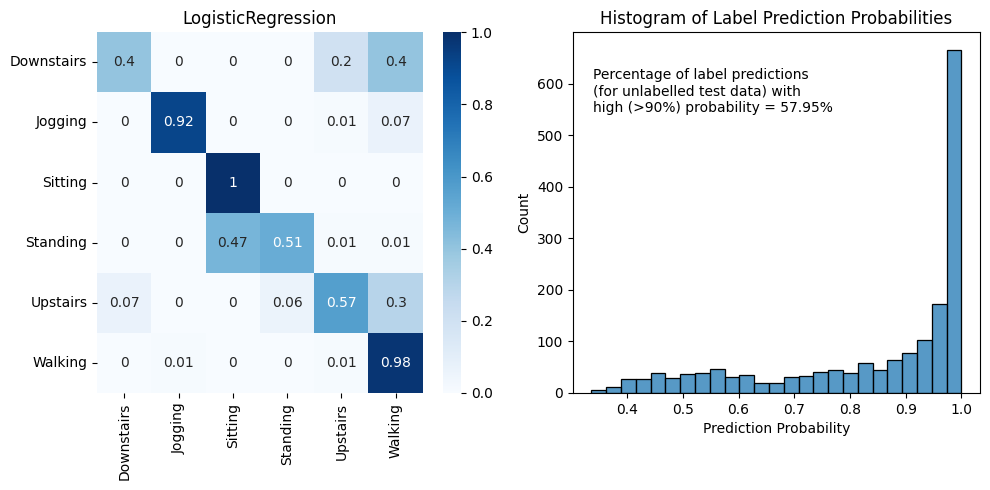

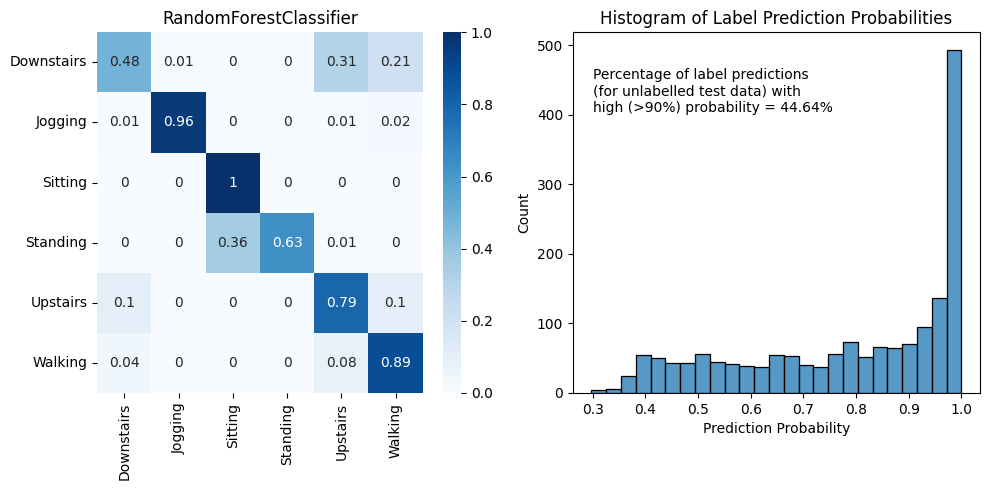

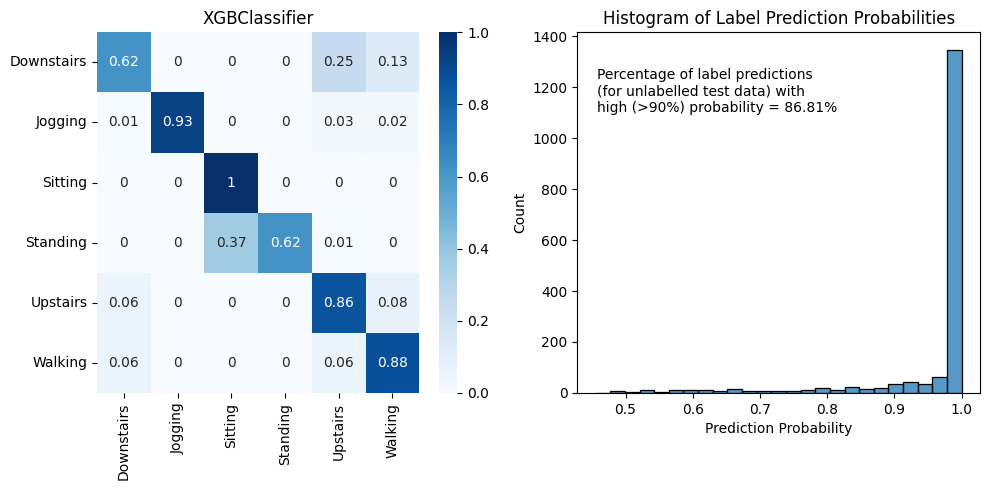

In [10]:
from sklearn.metrics import confusion_matrix

for model in models:
    test_mask = y_test.notna()
    X_test_eval = X_test[test_mask]
    y_test_eval = y_test[test_mask]
    y_pred_enc = model.predict(X_test_eval)
    y_pred_labels = [list(label_encoder.keys())[i] for i in y_pred_enc]

    labels_order = list(label_encoder.keys())
    cm = confusion_matrix(y_test_eval, y_pred_labels, labels=labels_order)
    cm = np.round((cm.T / cm.sum(axis=1)).T , 2)

    # Evaluation on test set - only on windows that have no actual label
    test_mask = y_test.isna()
    X_test_isna_eval = X_test[test_mask]

    y_test_isna_pred_enc = model.predict(X_test_isna_eval)
    y_test_isna_pred_prob = model.predict_proba(X_test_isna_eval)
    y_test_isna_pred_labels = [list(label_encoder.keys())[i] for i in y_test_isna_pred_enc]
    y_test_isna_gt90pcnt_conf = (y_test_isna_pred_prob >= 0.9).sum() / len(y_test_isna_pred_prob)

    prob_test = f"Percentage of label predictions \n(for unlabelled test data) with\n" + \
        f"high (>90%) probability = {round(y_test_isna_gt90pcnt_conf * 100, 2)}%"

    fig, ax = plt.subplots(ncols=2, figsize=(10,5))
    sns.heatmap(
        data=pd.DataFrame(cm, columns=label_encoder),
        ax=ax[0], cmap="Blues", annot=True, yticklabels=labels_order,
    )
    ax[0].set_title(f'{type(model).__name__}')
    sns.histplot(y_test_isna_pred_prob.max(axis=1), ax=ax[1], bins=25)
    ax[1].text(
        0.05, 0.9, prob_test, transform=ax[1].transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(facecolor='white', edgecolor="white", boxstyle='round,pad=0.3')
    )
    ax[1].set_title('Histogram of Label Prediction Probabilities')
    ax[1].set_xlabel('Prediction Probability')

    plt.tight_layout()